# EDA - NoMES


In [1]:
import pandas as pd

changes = pd.read_csv("data_2020.csv", nrows=500000, sep=';')
changes.head()

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year
0,649,3,10,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
1,529,36,8,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
2,651,14,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
3,531,2,22,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
4,532,5,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020


In [2]:
# check for missing values (month, days per month)
# lists months and days per month

# expected values = something


def check_missing_values():

    months = changes['month'].unique()

    for m in months:
        print(m)
        month = changes[changes['month'] == m]
        
        print(month['day'].unique())
        
        # compare to expected values
    # return difference


maxspaces = max(changes["bikesAvailable"])

print(changes[changes["bikesAvailable"] == maxspaces])

check_missing_values()

id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
325932  11             106                0             1               0   

             state  realTimeData                 time  week  yday  day  month  \
325932  Station on             1  2020/08/05 11:55:02    32   218    5      8   

        hour       minute  yhour  year  
325932    14  0,916666700   3254  2020  
8
[3 4 5 6]


In [4]:
# separate stations in their own dataframes

telling_ids = changes['id'].unique()
stations = {}

for i in telling_ids:
    station = changes[changes['id'] == i]
    stations[i] = station

print(len(stations))
print(stations[11])

450
        id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
132     11              37                6             1               0   
582     11              37                6             1               0   
1032    11              38                6             1               0   
1482    11              38                6             1               0   
1932    11              38                6             1               0   
...     ..             ...              ...           ...             ...   
497832  11              68                5             1               0   
498282  11              66                6             1               0   
498732  11              66                6             1               0   
499182  11              68                4             1               0   
499632  11              68                4             1               0   

             state  realTimeData                 time  week  yday  day 

In [5]:
# map station names to ids
# clean station names

def clean_names(names):
    # strip and removal of duplicates
    return set([name.strip() for name in names])


station_data = pd.read_csv("tellingit_2017-2021.csv", sep=';')
station_names = station_data[station_data['year'] == 2020]['name'].unique()
station_names = clean_names(station_names)
station_ids = station_data[station_data['year'] == 2020]['id'].unique()

names_ids = {}

for ids in station_ids:
    name = station_data[station_data['id'] == ids].iloc[0]['name']
    names_ids[ids] = name


print(names_ids[11])

Unioninkatu


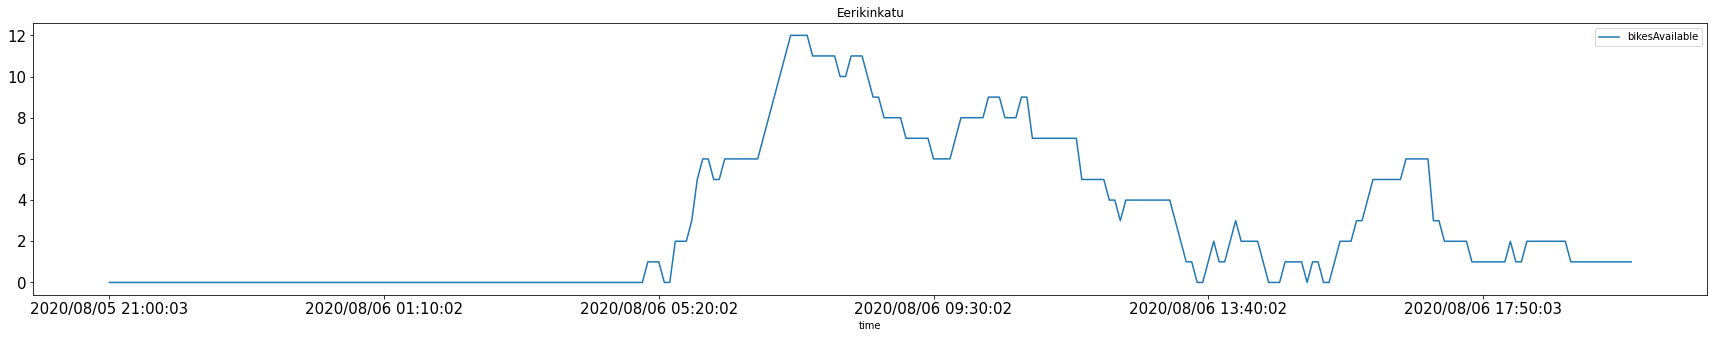

In [6]:
# plot changes per station over time X

import matplotlib.pyplot as plt

def filter_rows(yday: int, station_id: int, min_hour: int, max_hour: int) -> pd.DataFrame():
    yday = yday
    i = station_id
    station = stations[i]

    station = station[station['yday'] == yday]

    if min_hour is not None and max_hour is not None:
        station = station[(station['yhour'] >= min_hour) & (station['yhour'] <= max_hour)]

    return station


def plot_bike_changes(station_id, station):
    title = names_ids[station_id]
    station.plot(x='time', y='bikesAvailable', figsize=(30,5), fontsize=15, title=title)
    plt.savefig(f"img/{title}")

i = 27

station = filter_rows(219, i, None, None)
plot_bike_changes(i, station)


In [7]:
# Primary target: count how many times per day bikes drop to day's minimum

def count_drops(station):
    minbikes = min(station['bikesAvailable'])
    counts = 0
    was_min = False

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # drop starts
        if not was_min and bikes == minbikes:
            counts += 1
            was_min = True

        # drop ends
        elif was_min and bikes != minbikes:
            was_min = False

    return counts, minbikes

i = 113
station = filter_rows(219, i, None, None)
print(count_drops(station))
# plot_bike_changes(i, station)

(23, 2)


In [8]:
# Secondary target: Count the number of changes
# there is a change if the number of bikes is different than for the previous 5min (doesn't take into account the number of bikes changed)

def count_changes(station):
    counts = 0
    previous = -1

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # print(previous, bikes)
        if bikes != previous:
            # found change 
            counts += 1
            previous = bikes

        # print(counts)
    return counts

i = 11
station = filter_rows(218, i, None, None)
print("changes", count_changes(station))
# plot_bike_changes(i, station)

changes 124


In [9]:
# predict number of bikes

import numpy as numpy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

print('The scikit-learn version is {}.'.format(sklearn.__version__))

X = changes.drop(["bikesAvailable", "state", "time", "minute"], axis=1)
y = changes["bikesAvailable"]

print(len(X), len(y))

# test_size requires scikit-learn=0.24.0
tscv = TimeSeriesSplit(n_splits = 3, test_size=288)
print(tscv)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = LinearRegression()
rl = model.fit(X_train, y_train)

score = rl.score(X_test, y_test)
print(score)
# print(X_train)
predicted = rl.predict(X_test)
print(predicted)
print(y_test)

print(len(predicted), len(y_test))
predicted = pd.Series(predicted, index = y_test.index)
print(predicted)

The scikit-learn version is 0.24.0.
500000 500000
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=288)
TRAIN: [     0      1      2 ... 499133 499134 499135] TEST: [499136 499137 499138 499139 499140 499141 499142 499143 499144 499145
 499146 499147 499148 499149 499150 499151 499152 499153 499154 499155
 499156 499157 499158 499159 499160 499161 499162 499163 499164 499165
 499166 499167 499168 499169 499170 499171 499172 499173 499174 499175
 499176 499177 499178 499179 499180 499181 499182 499183 499184 499185
 499186 499187 499188 499189 499190 499191 499192 499193 499194 499195
 499196 499197 499198 499199 499200 499201 499202 499203 499204 499205
 499206 499207 499208 499209 499210 499211 499212 499213 499214 499215
 499216 499217 499218 499219 499220 499221 499222 499223 499224 499225
 499226 499227 499228 499229 499230 499231 499232 499233 499234 499235
 499236 499237 499238 499239 499240 499241 499242 499243 499244 499245
 499246 499247 499248 499249 499250 4

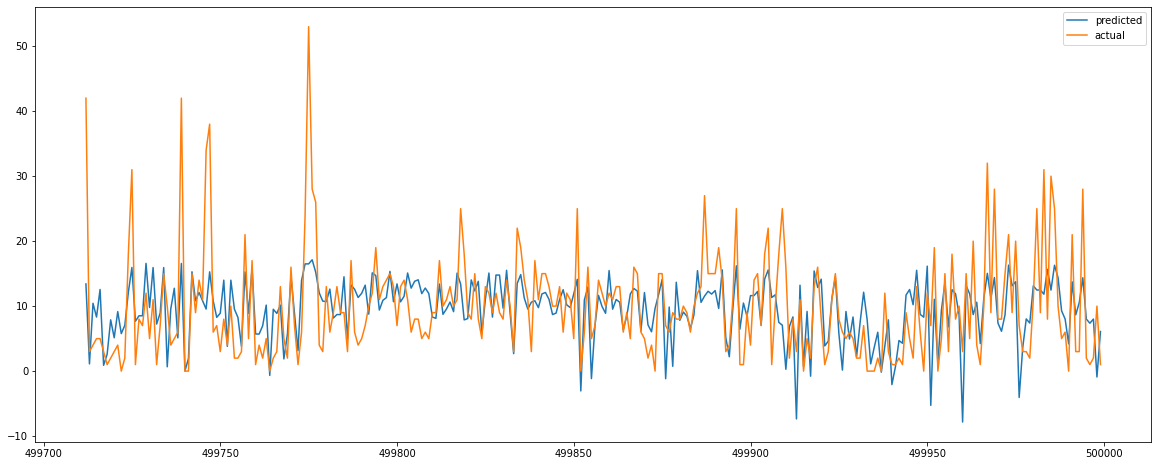

In [10]:
# plot predictions

plt.rcParams["figure.figsize"] = (20,8)
plt.plot(predicted, label="predicted")
plt.plot(y_test, label="actual")
plt.legend()
plt.show()